In [3]:
import os
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Directories
train_dir = "/kaggle/input/naruto-hand-sign-dataset/Pure Naruto Hand Sign Data/train"
test_dir = "/kaggle/input/naruto-hand-sign-dataset/Pure Naruto Hand Sign Data/test"

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 13
EPOCHS = 25

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,         # Increase rotation range
    width_shift_range=0.3,     # Increase width shift
    height_shift_range=0.3,    # Increase height shift
    zoom_range=0.3,            # Increase zoom range
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]  # Adjust brightness
)
# Test Data Generator (No Augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load Training Data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load Test Data
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load Pretrained VGG16
base_model = VGG16(
    weights='/kaggle/input/weights/tensorflow1/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)


for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers
    layer.trainable = True

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)  # Increase neurons for better feature extraction
x = Dropout(0.5)(x)                   # Dropout to prevent overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# Final Model
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-5),  # Reduced learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(
    "vgg16_naruto_hand_sign.keras",  # Updated file path to end with .keras
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(train_data.classes), 
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

# Include in model.fit()
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=EPOCHS,
    class_weight=class_weights,  # Add class weights
    callbacks=[checkpoint, early_stopping]
)

# Save the Final Model
model.save("final_model.keras")  # Updated file path to end with .keras

# Evaluate the Model on Test Data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Found 2159 images belonging to 13 classes.
Found 86 images belonging to 13 classes.
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0980 - loss: 2.8796
Epoch 1: val_accuracy improved from -inf to 0.05814, saving model to vgg16_naruto_hand_sign.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.0979 - loss: 2.8787 - val_accuracy: 0.0581 - val_loss: 2.5569
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.0977 - loss: 2.6747
Epoch 2: val_accuracy improved from 0.05814 to 0.16279, saving model to vgg16_naruto_hand_sign.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 60s 800ms/step - accuracy: 0.0979 - loss: 2.6740 - val_accuracy: 0.1628 - val_loss: 2.4912
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.1442 - loss: 2.5144
Epoch 3: val_accuracy improved from 0.16279 to 0.23256, saving model to vgg16_naruto_hand_sign.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 60s 793ms/step - accuracy: 0.1443 - loss: 2.5141 - val_accuracy: 0.2326 - val_loss: 2.3549
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.2045 - loss: 2.3306
Epoch 4: val_accur

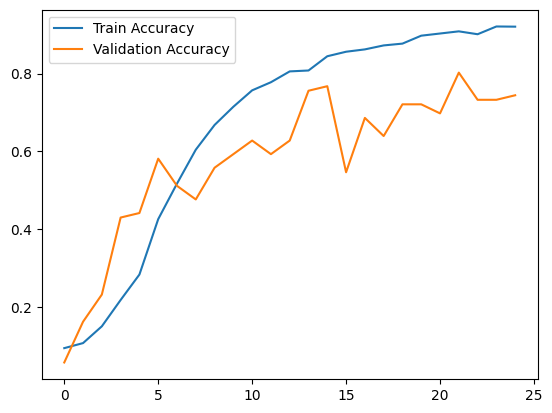

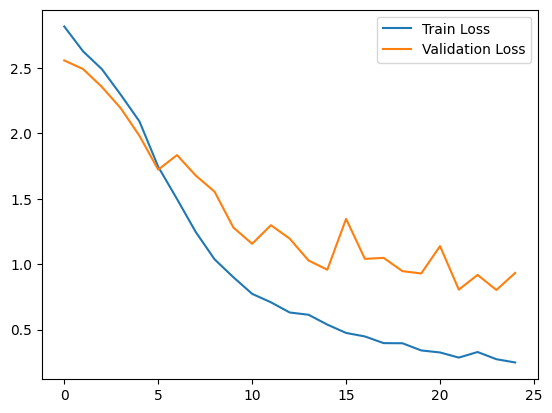

In [4]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()